In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from utils import *
path = "../nybolig-scrape/output_raw"
#try reloading the module
IMAGE_WIDTH: int = 224
IMAGE_HEIGHT: int = 224


# Load Data
# train_1_path: str = "output/train/train_1"
# train_2_path: str = "output/train/train_2"
# valid_path: str = "output/valid"
# test_path: str = "output/test"
train_1_path: str = "../nybolig-scrape/output/train/train_1"
train_2_path: str = "../nybolig-scrape/output/train/train_2"
valid_path: str = "../nybolig-scrape/output/valid"
test_path: str = "../nybolig-scrape/output/test"

# train_1_path: str = "output/train/train_1"
# train_2_path: str = "output/train/train_2"
# valid_path: str = "output/valid"
# test_path: str = "output/test"

train1_df, train2_df, valid_df, test_df = data_to_df(
    [train_1_path, train_2_path, valid_path, test_path], preprocess=False
)

houses_df = pd.concat([train1_df, train2_df, valid_df, test_df], ignore_index=True)

2024-05-17 09:57:21.979860: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 09:57:21.979934: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 09:57:22.048204: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-17 09:57:22.195032: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 09:57:23.870115: W tensorflow/compiler/tf2

In [3]:
print(len(houses_df))

890


# 1. Data Exploration

In [4]:
display(houses_df.head(1))
#Remove url 
houses_df = houses_df.drop(columns=["url"])
#houses_df_ = prepare_features(houses_df)
#display(houses_df_.head(1))

,url,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,postal_avg_sqm_price,lat,lng,image_floorplan
0,https://www.nybolig.dk/ejerlejlighed/2610/ager...,Agerskovvej 4D 2. 2610 Rødovre,2610,ejerlejlighed,1945000,70,None,2.0,1968.0,NaN,D,33273.25,56.5753563308919,8.2055979563106,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


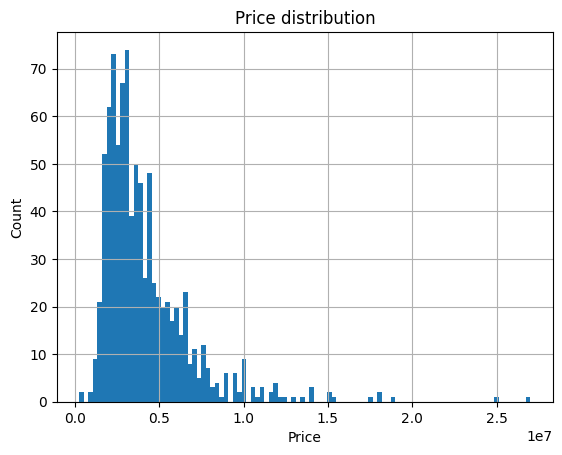

Mean price: 4156277.5280898875
Standard deviation price: 2706690.553201092
Lower tail (0.1): 1895000.0
Upper tail (0.9): 6995000.0
Lower tail amount: 86
Upper tail amount: 85
Total tail amount: 171
Total tail amount (%): 19.21%
Total datapoints: 890


In [17]:
# Print the distribution of the target variable
houses_df["price"].hist(bins=100)
plt.title("Price distribution")
plt.xlabel("Price")
plt.ylabel("Count")
# Draw a distribution line that represents the mean price
plt.show()

# Calculate the mean and standard deviation of the target variable
mean_price = houses_df["price"].mean()
std_price = houses_df["price"].std()
print(f"Mean price: {mean_price}")
print(f"Standard deviation price: {std_price}")

# Calculate the tail of the target variable
tail = 0.10
lower_tail = houses_df["price"].quantile(tail)
upper_tail = houses_df["price"].quantile(1 - tail)
print(f"Lower tail ({tail}): {lower_tail}")
print(f"Upper tail ({1 - tail}): {upper_tail}")

# Get the amount of data in the tails
lower_tail_amount = len(houses_df[houses_df["price"] < lower_tail])
upper_tail_amount = len(houses_df[houses_df["price"] > upper_tail])
total_amount_tail = lower_tail_amount + upper_tail_amount
print(f"Lower tail amount: {lower_tail_amount}")
print(f"Upper tail amount: {upper_tail_amount}")
print(f"Total tail amount: {total_amount_tail}")
print(f"Total datapoints: {len(houses_df)}")

Data description:


,postal_code,price,size,rooms,year_built,year_rebuilt,postal_avg_sqm_price
count,890.000000,8.900000e+02,890.000000,886.000000,885.000000,69.000000,890.000000
mean,2337.933708,4.156278e+06,83.103371,2.860045,1952.345763,1991.869565,41383.279213
std,429.623105,2.706691e+06,33.729228,1.049426,47.551118,23.500884,15214.893950
min,1051.000000,2.750000e+05,15.000000,0.000000,1623.000000,1933.000000,0.000000
25%,2100.000000,2.445000e+06,60.000000,2.000000,1932.000000,1978.000000,33507.500000
50%,2300.000000,3.347500e+06,76.000000,3.000000,1954.000000,1996.000000,44946.750000
75%,2680.000000,4.995000e+06,99.000000,4.000000,1981.000000,2009.000000,51502.500000
max,2900.000000,2.700000e+07,324.000000,8.000000,2023.000000,2022.000000,65007.000000


\begin{tabular}{lrrrrrrr}
\toprule
 & postal_code & price & size & rooms & year_built & year_rebuilt & postal_avg_sqm_price \\
\midrule
count & 890 & 890 & 890 & 886 & 885 & 69 & 890 \\
mean & 2337 & 4156277 & 83 & 2 & 1952 & 1991 & 41383 \\
std & 429 & 2706690 & 33 & 1 & 47 & 23 & 15214 \\
min & 1051 & 275000 & 15 & 0 & 1623 & 1933 & 0 \\
25% & 2100 & 2445000 & 60 & 2 & 1932 & 1978 & 33507 \\
50% & 2300 & 3347500 & 76 & 3 & 1954 & 1996 & 44946 \\
75% & 2680 & 4995000 & 99 & 4 & 1981 & 2009 & 51502 \\
max & 2900 & 27000000 & 324 & 8 & 2023 & 2022 & 65007 \\
\bottomrule
\end{tabular}



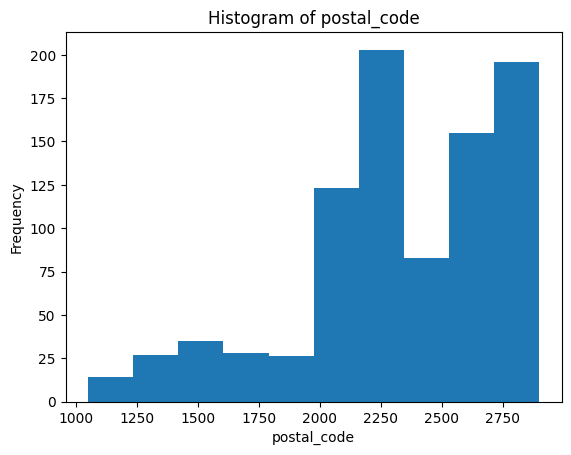

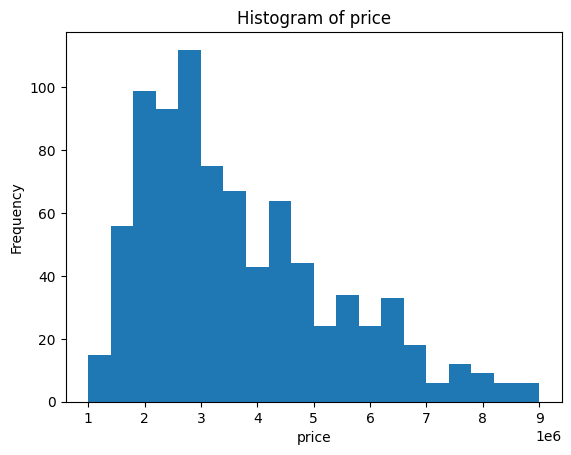

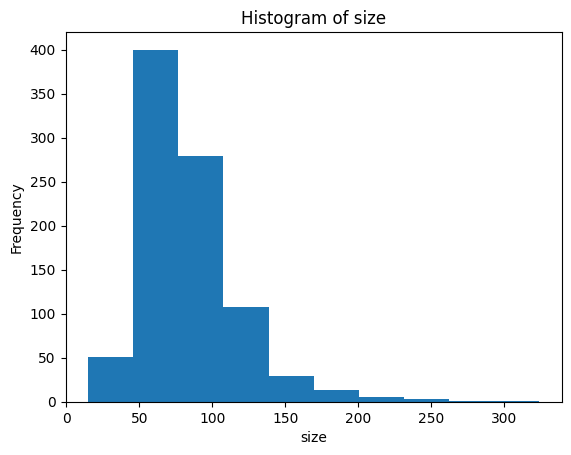

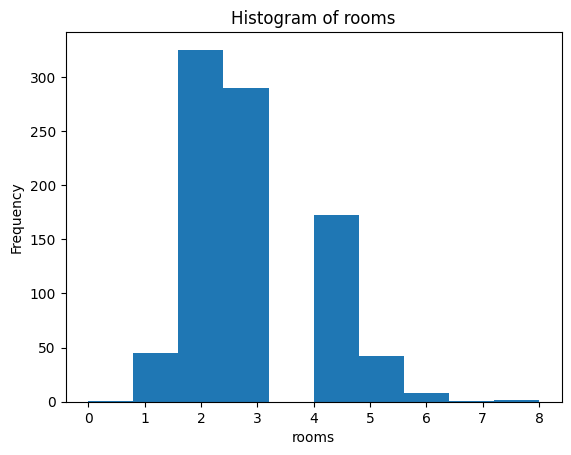

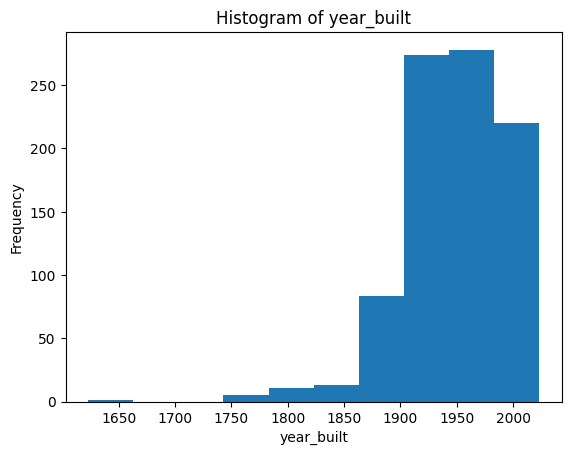

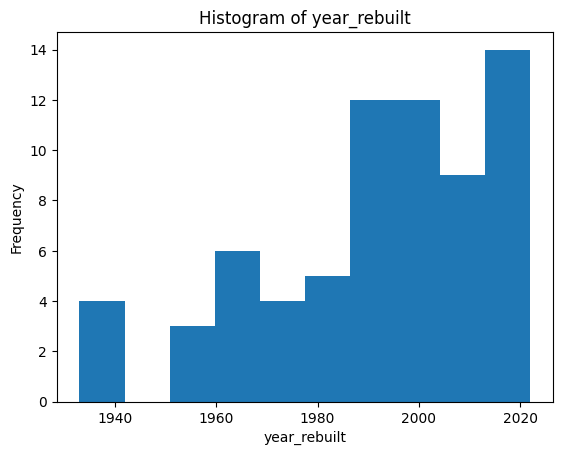

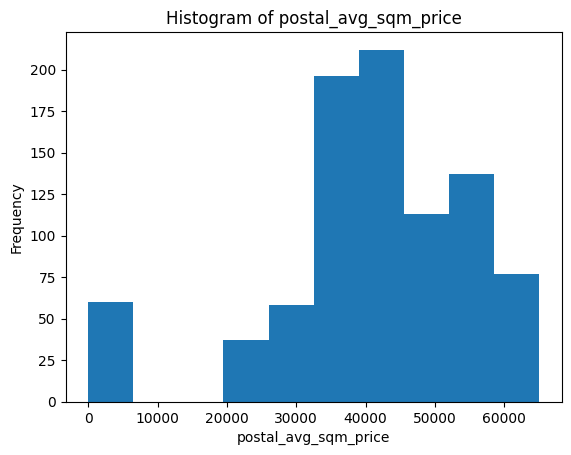

ValueError: could not convert string to float: 'Agerskovvej 4D 2. 2610 Rødovre'

<Figure size 1200x1000 with 0 Axes>

In [5]:
from DataExploration import full_summary
full_summary(houses_df)